# FrameType Comparison

Make dataframes via factory method for easier comparison.

* NOTE: cudf can handoff to pandas dataframes.  In production, factory not necessary unless try/except required for environment interoperability.  At that point, imports should be moved into the factory else rapids incompatible environments won't test at all.

In [1]:
import cudf
import pandas as pd
import numpy as np

dfbuilders = {}

class FrameFactory():
    def __init__(self, dftype):
        self.builder = dfbuilders[dftype]
    def __call__(self, data, **kwargs):
        return self.builder(data)


def build_pandas_frame(data, **kwargs):
    return pd.DataFrame(data, **kwargs)
dfbuilders['pandas'] = build_pandas_frame

def build_cudf_frame(data, **kwargs):
    return cudf.DataFrame(data, **kwargs)
dfbuilders['cudf'] = build_cudf_frame


def generate_random_data(n):
    def fake_let(n):
        return np.random.choice(['a','b','c'], n)
    def fake_num(n):
        return np.random.randint(0, 10, n)
    return {
        'let': fake_let(n),
        'num': fake_num(n)
    }

## Generate Test Data
Generate sample data to test query, aggregation, and blocking speeds.

**ATTACHED STORAGE MAY BE VERY SLOW**
* For this comparision, data is generated and kept in memory.  Attached storage and access latency causing problems.

In [2]:
%%timeit
dfac = FrameFactory('cudf') ## options 'pandas' or 'cudf'
dfc = dfac(generate_random_data(1000000))

153 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
%%timeit
dfac = FrameFactory('pandas') ## options 'pandas' or 'cudf'
dfp = dfac(generate_random_data(1000000))

92.7 ms ± 663 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Dataframe Creation Time
Pandas dataframe creation is ~1.25x to 2x faster.  Both are reasonably fast for mixed data types.

In [4]:
import time

def time_fn(fn, runs=2, *args, **kwargs):
    times = []
    for _ in range(runs):
        st = time.time()
        fn(*args, **kwargs)
        times.append(time.time() - st)
    return sum(times) / len(times)

In [8]:
def nsum(*args):
    print('hello', sum(args))
    
time_fn(nsum, 2, 2, 3, 4)

hello 9
hello 9


0.00016009807586669922

## Built In Aggregation

Testing simple aggregations

In [48]:
dfacc = FrameFactory('cudf')
dfacp = FrameFactory('pandas')

cseries = [dfacc(generate_random_data(n)) for n in [10**4, 10**5, 10**6, 10**7, 10**8]]
pseries = [dfacp(generate_random_data(n)) for n in [10**4, 10**5, 10**6, 10**7, 10**8]]

In [49]:
def bsum(x):
    return x.num.sum()

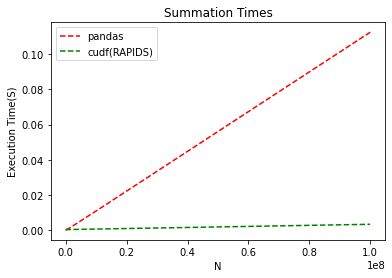

In [55]:
import matplotlib.pyplot as plt
pst = [time_fn(bsum, 2, pseries[i]) for i in range(len(pseries))]
cst = [time_fn(bsum, 2, cseries[i]) for i in range(len(cseries))]

plt.plot([len(x) for x in pseries], pst, 'r--', label='pandas')
plt.plot([len(x) for x in cseries], cst, 'g--', label='cudf(RAPIDS)')
plt.title('Summation Times')
plt.ylabel('Execution Time(S)')
plt.xlabel('N')
plt.legend()
plt.show()

In [51]:
def groupsum(x):
    return x.groupby(['let']).sum(), x.groupby(['num']).count()

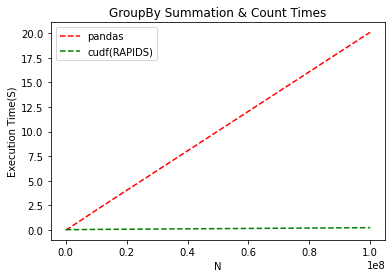

In [56]:
import matplotlib.pyplot as plt
pst = [time_fn(groupsum, 2, pseries[i]) for i in range(len(pseries))]
cst = [time_fn(groupsum, 2, cseries[i]) for i in range(len(cseries))]

plt.plot([len(x) for x in pseries], pst, 'r--', label='pandas')
plt.plot([len(x) for x in cseries], cst, 'g--', label='cudf(RAPIDS)')
plt.title('GroupBy Summation & Count Times')
plt.ylabel('Execution Time(S)')
plt.xlabel('N')
plt.legend()
plt.show()